In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
import os

# Load the dataset
df = pd.read_csv("/content/emotions.csv")

# Inspect first few rows
print(df.head())
print(df.columns)

   # mean_0_a  mean_1_a  mean_2_a  mean_3_a  mean_4_a  mean_d_0_a  mean_d_1_a  \
0        4.62      30.3    -356.0      15.6      26.3       1.070       0.411   
1       28.80      33.1      32.0      25.8      22.8       6.550       1.680   
2        8.90      29.4    -416.0      16.7      23.7      79.900       3.360   
3       14.90      31.6    -143.0      19.8      24.3      -0.584      -0.284   
4       28.30      31.3      45.2      27.3      24.5      34.800      -5.790   

   mean_d_2_a  mean_d_3_a  mean_d_4_a  ...  fft_741_b  fft_742_b  fft_743_b  \
0      -15.70        2.06        3.15  ...       23.5       20.3       20.3   
1        2.88        3.83       -4.82  ...      -23.3      -21.8      -21.8   
2       90.20       89.90        2.03  ...      462.0     -233.0     -233.0   
3        8.82        2.30       -1.97  ...      299.0     -243.0     -243.0   
4        3.06       41.40        5.52  ...       12.0       38.1       38.1   

   fft_744_b  fft_745_b  fft_746_b  ff

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Load and clean data
df = pd.read_csv("/content/emotions.csv")
df.rename(columns={df.columns[0]: 'mean_0_a'}, inplace=True)  # Fix column name

X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Number of classes
num_classes = len(np.unique(y_encoded))

# Stratified 10-Fold CV
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Training config
input_dim = X_scaled.shape[1]
init = HeNormal()

fold_accuracies = []
# Train the model
for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y_encoded)):
    print(f"\n--- Fold {fold+1} ---")

    model = Sequential([
        Dense(512, kernel_initializer=init, input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, kernel_initializer=init),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Fixed to match actual label count
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [
        EarlyStopping(patience=12, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=5)
    ]

    model.fit(X_scaled[train_idx], y_cat[train_idx],
              validation_data=(X_scaled[val_idx], y_cat[val_idx]),
              epochs=10, batch_size=64,
              class_weight=class_weight_dict,
              callbacks=callbacks, verbose=1)
    score = model.evaluate(X_scaled[val_idx], y_cat[val_idx], verbose=0)
    fold_accuracies.append(score[1])  # score[1] = accuracy
    print(f"Validation Accuracy (Fold {fold+1}): {score[1]:.4f}")


print("\n=== Cross-Validation Summary ===")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1} Accuracy: {acc:.4f}")
print(f"\nAverage Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")


--- Fold 1 ---
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7497 - loss: 0.8455 - val_accuracy: 0.9159 - val_loss: 0.9238 - learning_rate: 0.0010
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8744 - loss: 0.3899 - val_accuracy: 0.8785 - val_loss: 0.6834 - learning_rate: 0.0010
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9064 - loss: 0.2719 - val_accuracy: 0.9159 - val_loss: 0.4033 - learning_rate: 0.0010
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9226 - loss: 0.2293 - val_accuracy: 0.8832 - val_loss: 0.3218 - learning_rate: 0.0010
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9296 - loss: 0.2136 - val_accuracy: 0.9299 - val_loss: 0.2949 - learning_rate: 0.0010
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9347 - loss: 0.1916 - val_accuracy: 0.9393 - val_loss: 0.2868 - learning_rate: 0.0010
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9455 - loss: 0.1893 - val_accuracy: 0.94

In [ ]:
X_reshaped = X_scaled.reshape(-1, 98, 26)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Reshape features for CNN
X_cnn = X_scaled.reshape(-1, 98, 26)

cnn_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_cnn, y_encoded)):
    print(f"\n--- Fold {fold+1} (CNN) ---")

    inp = Input(shape=(98, 26))
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inp)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_cnn[train_idx], y_cat[train_idx],
              validation_data=(X_cnn[val_idx], y_cat[val_idx]),
              epochs=10, batch_size=32,
              callbacks=callbacks,
              class_weight=class_weight_dict,
              verbose=1)

    score = model.evaluate(X_cnn[val_idx], y_cat[val_idx], verbose=0)
    cnn_accuracies.append(score[1])
    print(f"Validation Accuracy (Fold {fold+1}): {score[1]:.4f}")


--- Fold 1 (CNN) ---
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6979 - loss: 0.8081 - val_accuracy: 0.8598 - val_loss: 0.3297 - learning_rate: 0.0010
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9344 - loss: 0.1817 - val_accuracy: 0.9206 - val_loss: 0.2079 - learning_rate: 0.0010
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9481 - loss: 0.1325 - val_accuracy: 0.9579 - val_loss: 0.1516 - learning_rate: 0.0010
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9782 - loss: 0.0627 - val_accuracy: 0.9579 - val_loss: 0.1423 - learning_rate: 0.0010
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9860 - loss: 0.0461 - val_accuracy: 0.9579 - val_loss: 0.1145 - learning_rate: 0.0010
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9940 - loss: 0.0273 - val_accuracy: 0.9720 - val_loss: 0.0855 - learning_rate: 0.0010
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 1.0000 - 

In [ ]:
from sklearn.model_selection import train_test_split

# One-hot encode full labels
y_cat_full = to_categorical(y_encoded, num_classes=num_classes)

# 90/10 Train+Val vs Test split
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42)

# One-hot encode for training
y_trainval_cat = to_categorical(y_trainval, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Reshape for CNN/LSTM
X_trainval_seq = X_trainval.reshape(-1, 98, 26)
X_test_seq = X_test.reshape(-1, 98, 26)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
]


In [ ]:
from tensorflow.keras.layers import Activation
dnn_test_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval, y_trainval)):
    print(f"\n=== Fold {fold+1} (DNN) ===")

    model = Sequential([
        Dense(512, kernel_initializer='he_normal', input_shape=(X_trainval.shape[1],)),
        BatchNormalization(), Activation('relu'), Dropout(0.5),
        Dense(256, kernel_initializer='he_normal'),
        BatchNormalization(), Activation('relu'), Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_trainval[train_idx], y_trainval_cat[train_idx],
              validation_data=(X_trainval[val_idx], y_trainval_cat[val_idx]),
              epochs=8, batch_size=64, callbacks=callbacks, verbose=1,
              class_weight=class_weight_dict)

# Final test evaluation
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
dnn_test_accuracies.append(test_acc)
print(f"✅ DNN Test Accuracy: {test_acc:.4f}")



=== Fold 1 (DNN) ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7624 - loss: 0.6305 - val_accuracy: 0.9219 - val_loss: 0.4523 - learning_rate: 0.0010
Epoch 2/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8998 - loss: 0.3022 - val_accuracy: 0.9375 - val_loss: 0.2372 - learning_rate: 0.0010
Epoch 3/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9204 - loss: 0.2306 - val_accuracy: 0.9375 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 4/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9248 - loss: 0.1973 - val_accuracy: 0.9427 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 5/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9386 - loss: 0.1693 - val_accuracy: 0.9635 - val_loss: 0.1112 - learning_rate: 0.0010
Epoch 6/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9360 - loss: 0.1627 - val_accuracy: 0.9635 - val_loss: 0.1090 - learning_rate: 0.0010
Epoch 7/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9554 - loss: 0.1264 - val_accuracy: 

In [ ]:
cnn_test_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval_seq, y_trainval)):
    print(f"\n=== Fold {fold+1} (CNN) ===")

    inp = Input(shape=(98, 26))
    x = Conv1D(64, 3, padding='same', activation='relu')(inp)
    x = MaxPooling1D()(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D()(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_trainval_seq[train_idx], y_trainval_cat[train_idx],
              validation_data=(X_trainval_seq[val_idx], y_trainval_cat[val_idx]),
              epochs=8, batch_size=64, callbacks=callbacks,
              class_weight=class_weight_dict, verbose=1)

test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)
cnn_test_accuracies.append(test_acc)
print(f"✅ CNN Test Accuracy: {test_acc:.4f}")



=== Fold 1 (CNN) ===
Epoch 1/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6310 - loss: 1.0225 - val_accuracy: 0.9271 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 2/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9161 - loss: 0.2362 - val_accuracy: 0.9375 - val_loss: 0.1537 - learning_rate: 0.0010
Epoch 3/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9342 - loss: 0.1753 - val_accuracy: 0.9688 - val_loss: 0.1248 - learning_rate: 0.0010
Epoch 4/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9600 - loss: 0.1034 - val_accuracy: 0.9583 - val_loss: 0.1444 - learning_rate: 0.0010
Epoch 5/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9716 - loss: 0.0851 - val_accuracy: 0.9792 - val_loss: 0.1176 - learning_rate: 0.0010
Epoch 6/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9904 - loss: 0.0423 - val_accuracy: 0.9583 - val_loss: 0.1026 - learning_rate: 0.0010
Epoch 7/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9892 - loss: 0

In [ ]:
from tensorflow.keras.layers import LSTM

lstm_test_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval_seq, y_trainval)):
    print(f"\n=== Fold {fold+1} (LSTM) ===")

    inp = Input(shape=(98, 26))
    x = LSTM(64, return_sequences=True)(inp)
    x = LSTM(32)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_trainval_seq[train_idx], y_trainval_cat[train_idx],
              validation_data=(X_trainval_seq[val_idx], y_trainval_cat[val_idx]),
              epochs=8, batch_size=64, callbacks=callbacks,
              class_weight=class_weight_dict, verbose=1)

test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)
lstm_test_accuracies.append(test_acc)
print(f"✅ LSTM Test Accuracy: {test_acc:.4f}")



=== Fold 1 (LSTM) ===
Epoch 1/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.5870 - loss: 0.9321 - val_accuracy: 0.8490 - val_loss: 0.5208 - learning_rate: 0.0010
Epoch 2/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.8431 - loss: 0.4322 - val_accuracy: 0.8802 - val_loss: 0.3134 - learning_rate: 0.0010
Epoch 3/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.8951 - loss: 0.2787 - val_accuracy: 0.9167 - val_loss: 0.2475 - learning_rate: 0.0010
Epoch 4/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8846 - loss: 0.2609 - val_accuracy: 0.9115 - val_loss: 0.1982 - learning_rate: 0.0010
Epoch 5/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9122 - loss: 0.2243 - val_accuracy: 0.9323 - val_loss: 0.1869 - learning_rate: 0.0010
Epoch 6/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9287 - loss: 0.1964 - val_accuracy: 0.9375 - val_loss: 0.1741 - learning_rate: 0.0010
Epoch 7/8
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9373 

In [ ]:
cnn_lstm_test_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_trainval_seq, y_trainval)):
    print(f"\n=== Fold {fold+1} (CNN-LSTM) ===")

    inp = Input(shape=(98, 26))
    x = Conv1D(64, 3, padding='same', activation='relu')(inp)
    x = MaxPooling1D()(x)
    x = Conv1D(128, 3, padding='same', activation='relu')(x)
    x = MaxPooling1D()(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(32)(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)

    model = Model(inp, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_trainval_seq[train_idx], y_trainval_cat[train_idx],
              validation_data=(X_trainval_seq[val_idx], y_trainval_cat[val_idx]),
              epochs=10, batch_size=32, callbacks=callbacks,
              class_weight=class_weight_dict, verbose=1)

test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat, verbose=0)
cnn_lstm_test_accuracies.append(test_acc)
print(f"✅ CNN-LSTM Test Accuracy: {test_acc:.4f}")



=== Fold 1 (CNN-LSTM) ===
Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.7130 - loss: 0.6935 - val_accuracy: 0.9375 - val_loss: 0.2270 - learning_rate: 0.0010
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8866 - loss: 0.3374 - val_accuracy: 0.8854 - val_loss: 0.2669 - learning_rate: 0.0010
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9012 - loss: 0.2694 - val_accuracy: 0.9271 - val_loss: 0.1848 - learning_rate: 0.0010
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9370 - loss: 0.2011 - val_accuracy: 0.9427 - val_loss: 0.1710 - learning_rate: 0.0010
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9372 - loss: 0.1850 - val_accuracy: 0.9479 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9344 - loss: 0.1988 - val_accuracy: 0.9427 - val_loss: 0.1927 - learning_rate: 0.0010
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.95

In [ ]:
dnn_model = model

In [ ]:
cnn_model = model

In [ ]:
lstm_model = model

In [ ]:
cnn_lstm_model = model

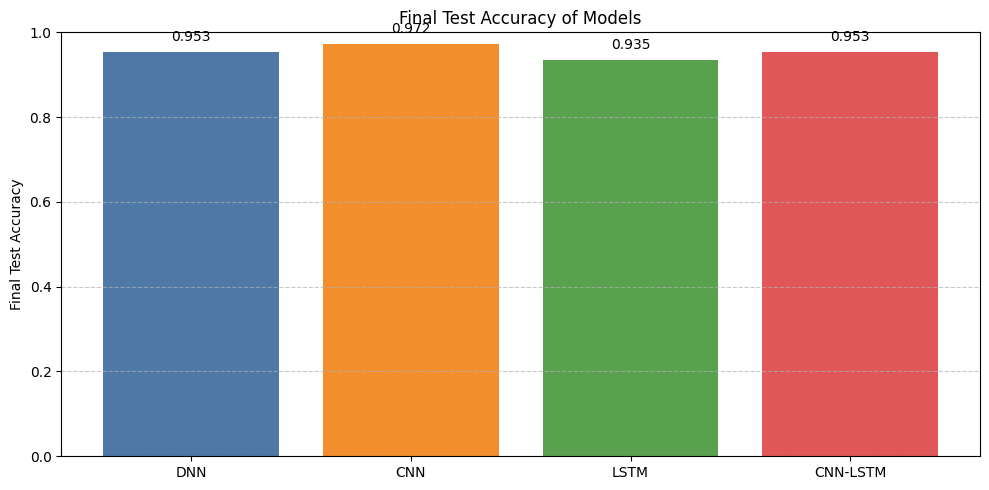

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual test accuracy values (mean of 10 folds)
dnn_acc = np.mean(dnn_test_accuracies)
cnn_acc = np.mean(cnn_test_accuracies)
lstm_acc = np.mean(lstm_test_accuracies)
cnn_lstm_acc = np.mean(cnn_lstm_test_accuracies)

model_names = ['DNN', 'CNN', 'LSTM', 'CNN-LSTM']
final_accuracies = [dnn_acc, cnn_acc, lstm_acc, cnn_lstm_acc]

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(model_names, final_accuracies, color=['#4e79a7', '#f28e2b', '#59a14f', '#e15759'])
plt.ylabel('Final Test Accuracy')
plt.ylim(0, 1)
plt.title('Final Test Accuracy of Models')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with accuracy value
for bar, acc in zip(bars, final_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02, f"{acc:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


Checking model input shapes:
DNN model expects input shape: (None, 98, 26)
CNN model expects input shape: (None, 98, 26)
LSTM model expects input shape: (None, 98, 26)
CNN-LSTM model expects input shape: (None, 98, 26)

Test data shape: (214, 2548)
Total features: 2548
Potential reshape dimensions (rows, cols): [(1, 2548), (2, 1274), (4, 637), (7, 364), (13, 196), (14, 182), (26, 98), (28, 91), (49, 52)]
Best reshape dimensions: (49, 52)

========== DNN MODEL PERFORMANCE ==========
Error evaluating DNN: as_list() is not defined on an unknown TensorShape.
Model input shape: (None, 98, 26)
Data shape: (214, 2548)

========== CNN MODEL PERFORMANCE ==========
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


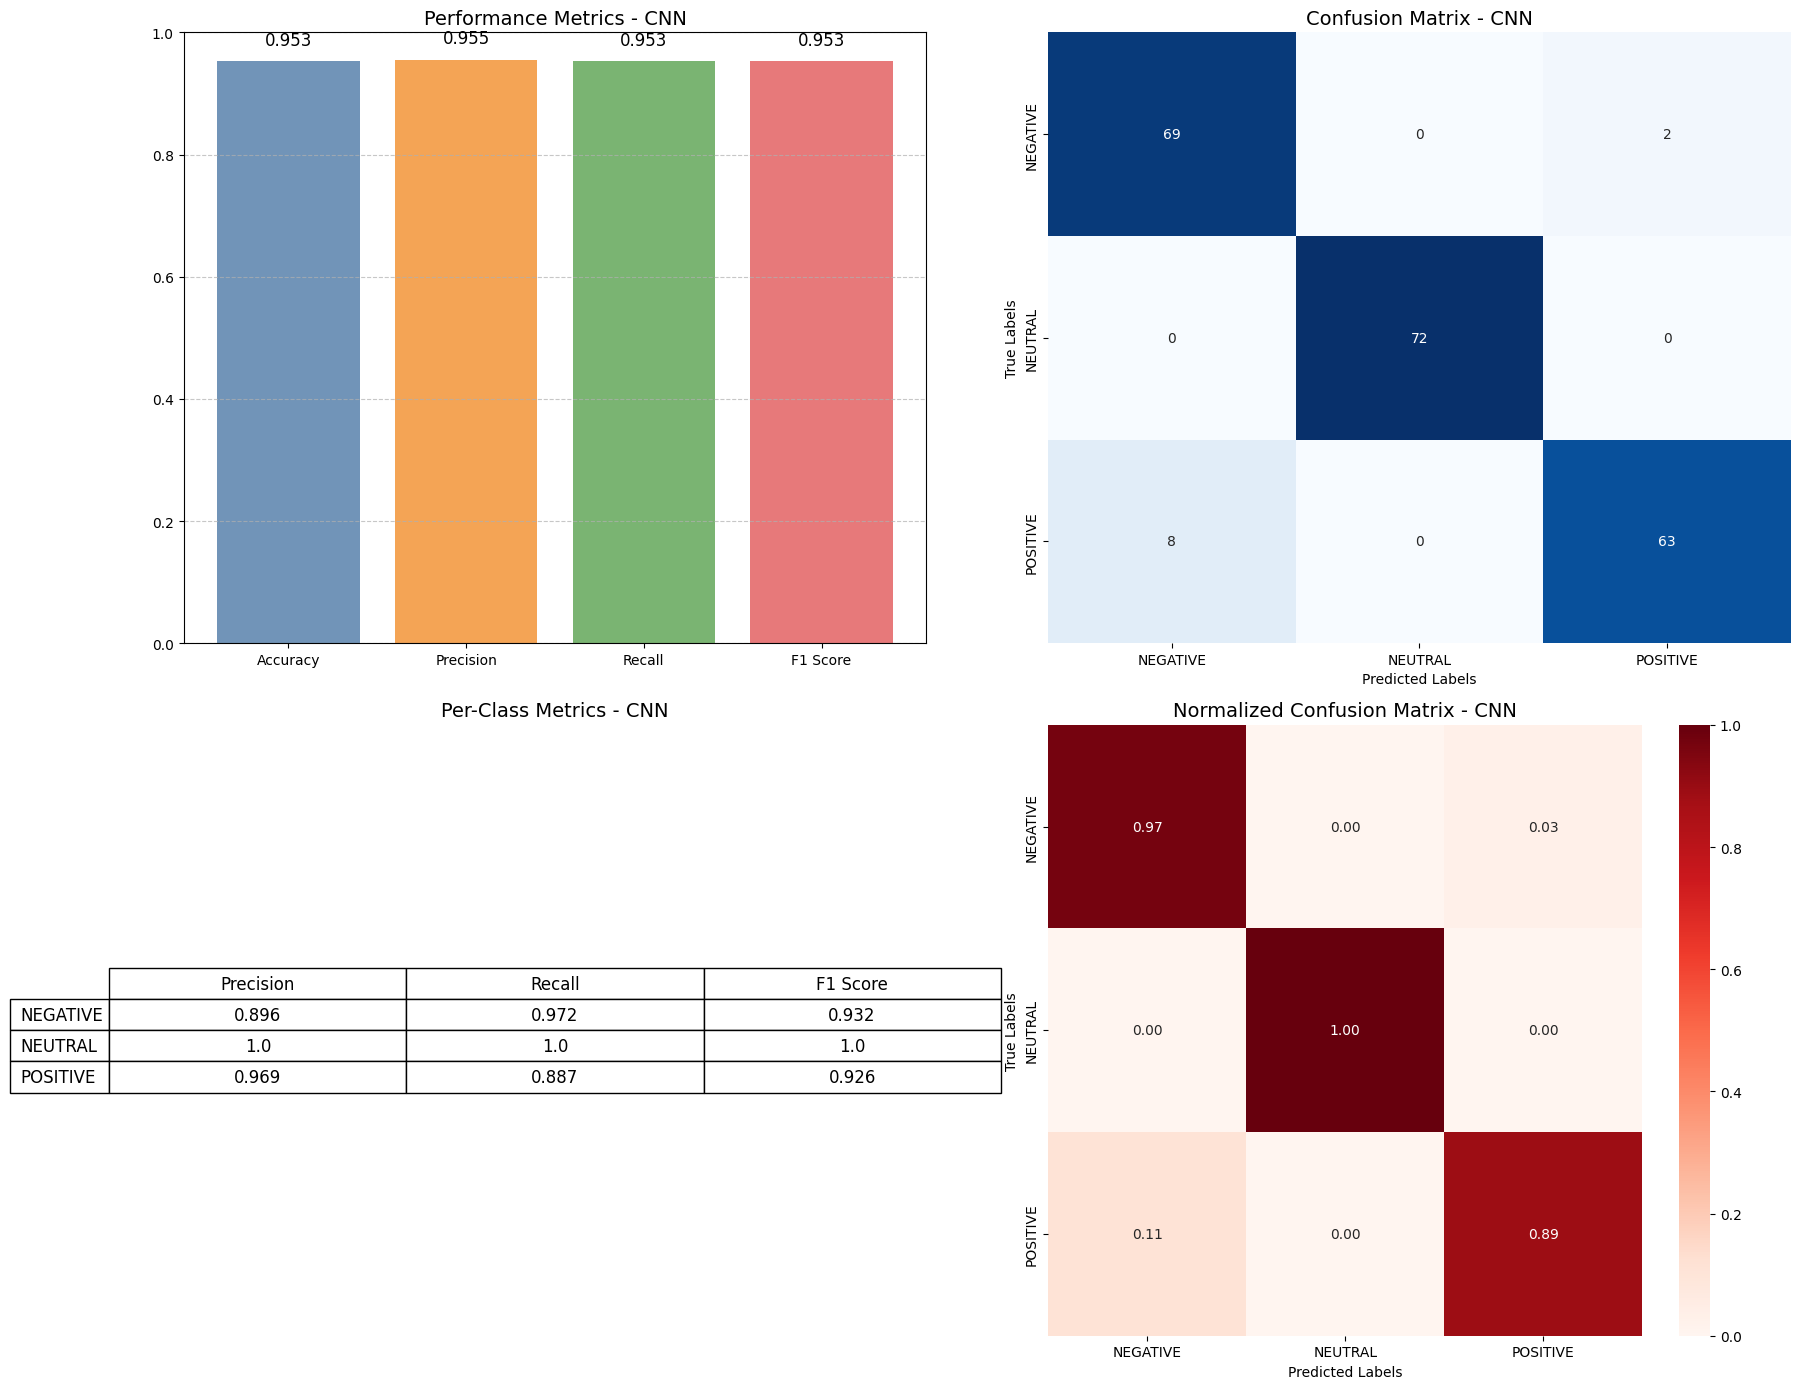


--- Classification Report for CNN ---
              precision    recall  f1-score   support

    NEGATIVE       0.90      0.97      0.93        71
     NEUTRAL       1.00      1.00      1.00        72
    POSITIVE       0.97      0.89      0.93        71

    accuracy                           0.95       214
   macro avg       0.96      0.95      0.95       214
weighted avg       0.96      0.95      0.95       214


========== LSTM MODEL PERFORMANCE ==========
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


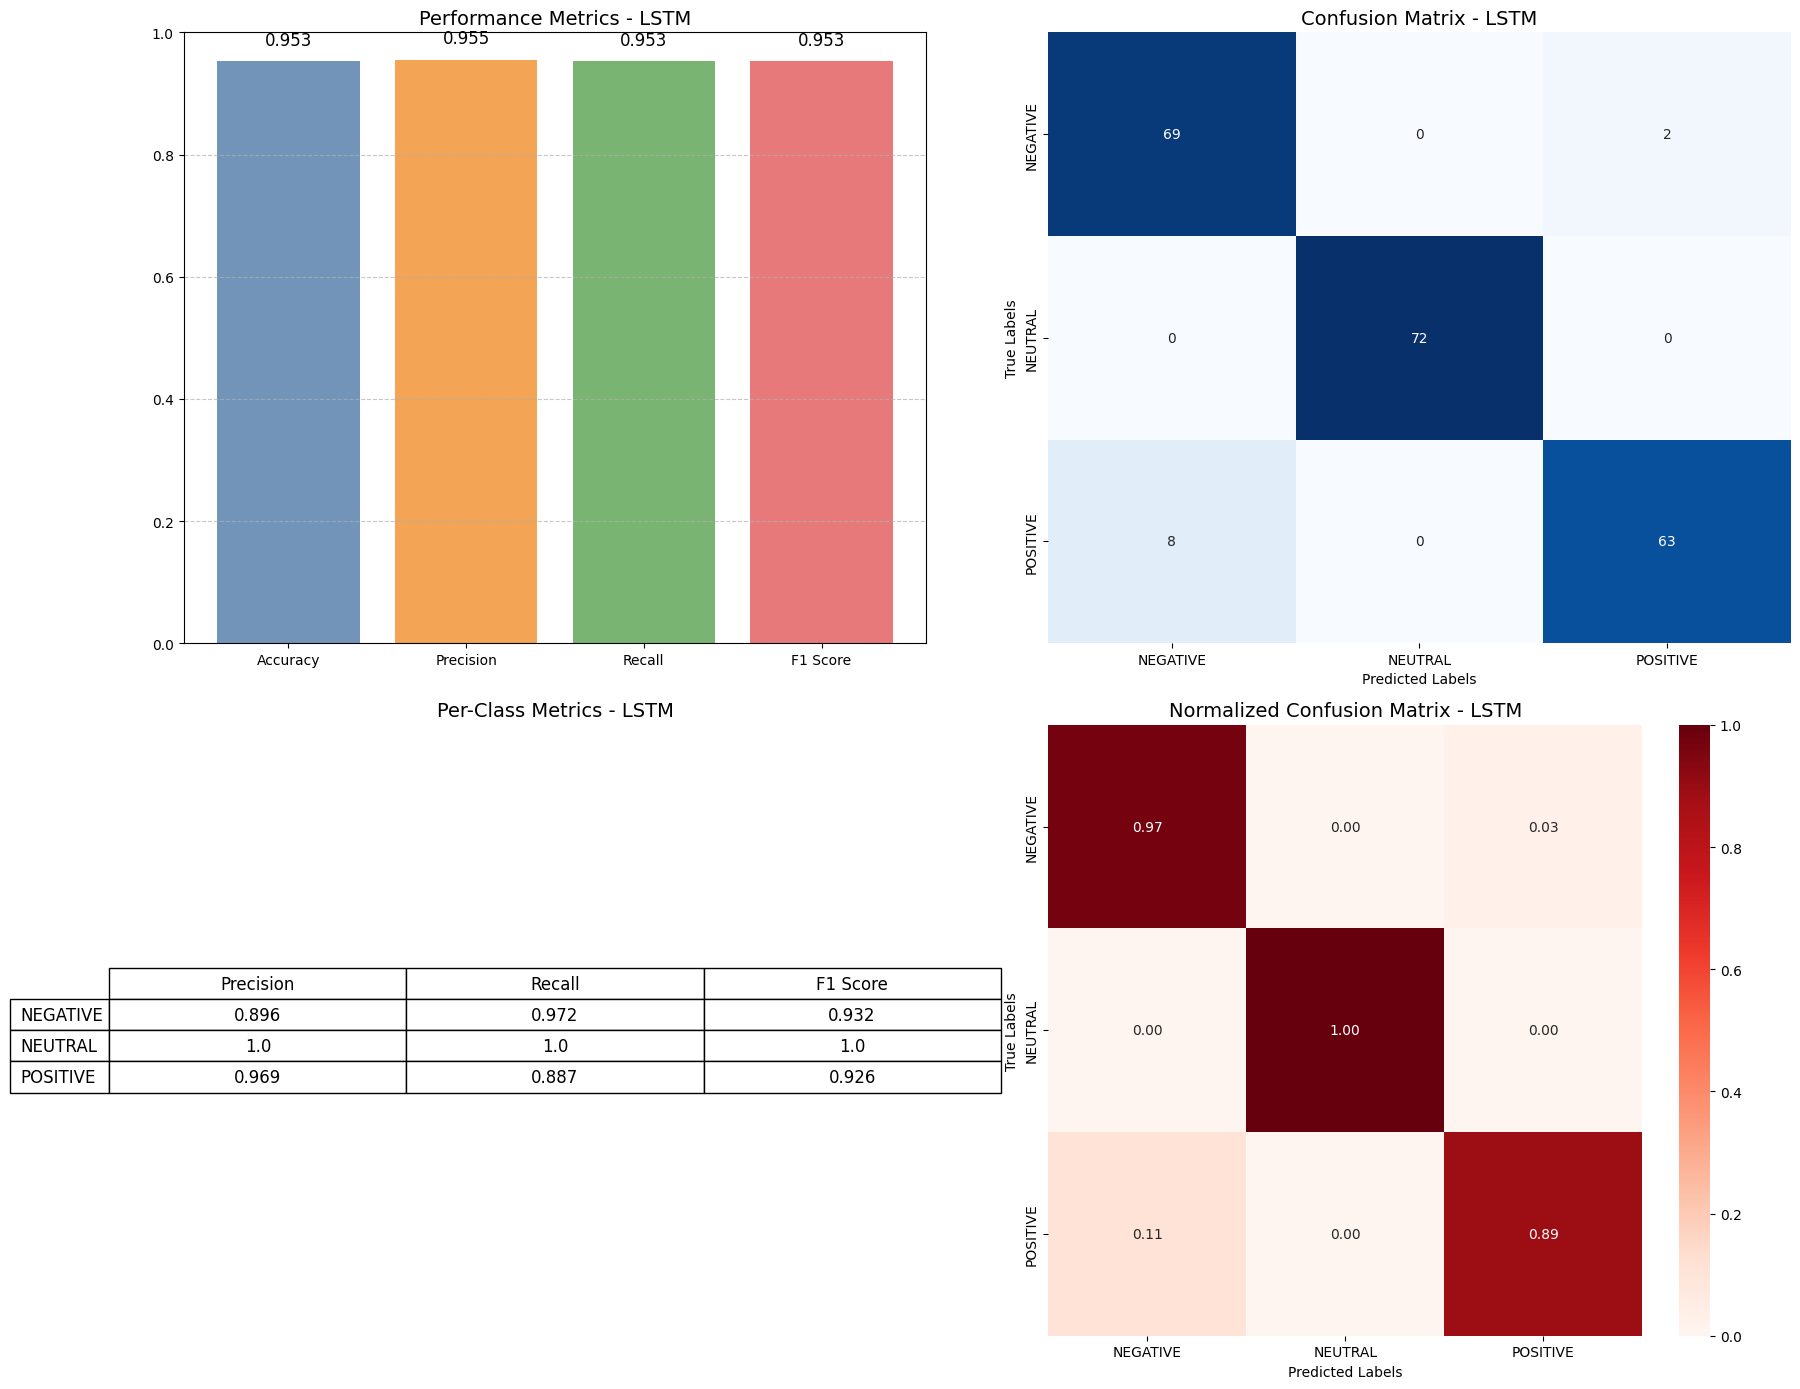


--- Classification Report for LSTM ---
              precision    recall  f1-score   support

    NEGATIVE       0.90      0.97      0.93        71
     NEUTRAL       1.00      1.00      1.00        72
    POSITIVE       0.97      0.89      0.93        71

    accuracy                           0.95       214
   macro avg       0.96      0.95      0.95       214
weighted avg       0.96      0.95      0.95       214


========== CNN-LSTM MODEL PERFORMANCE ==========
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


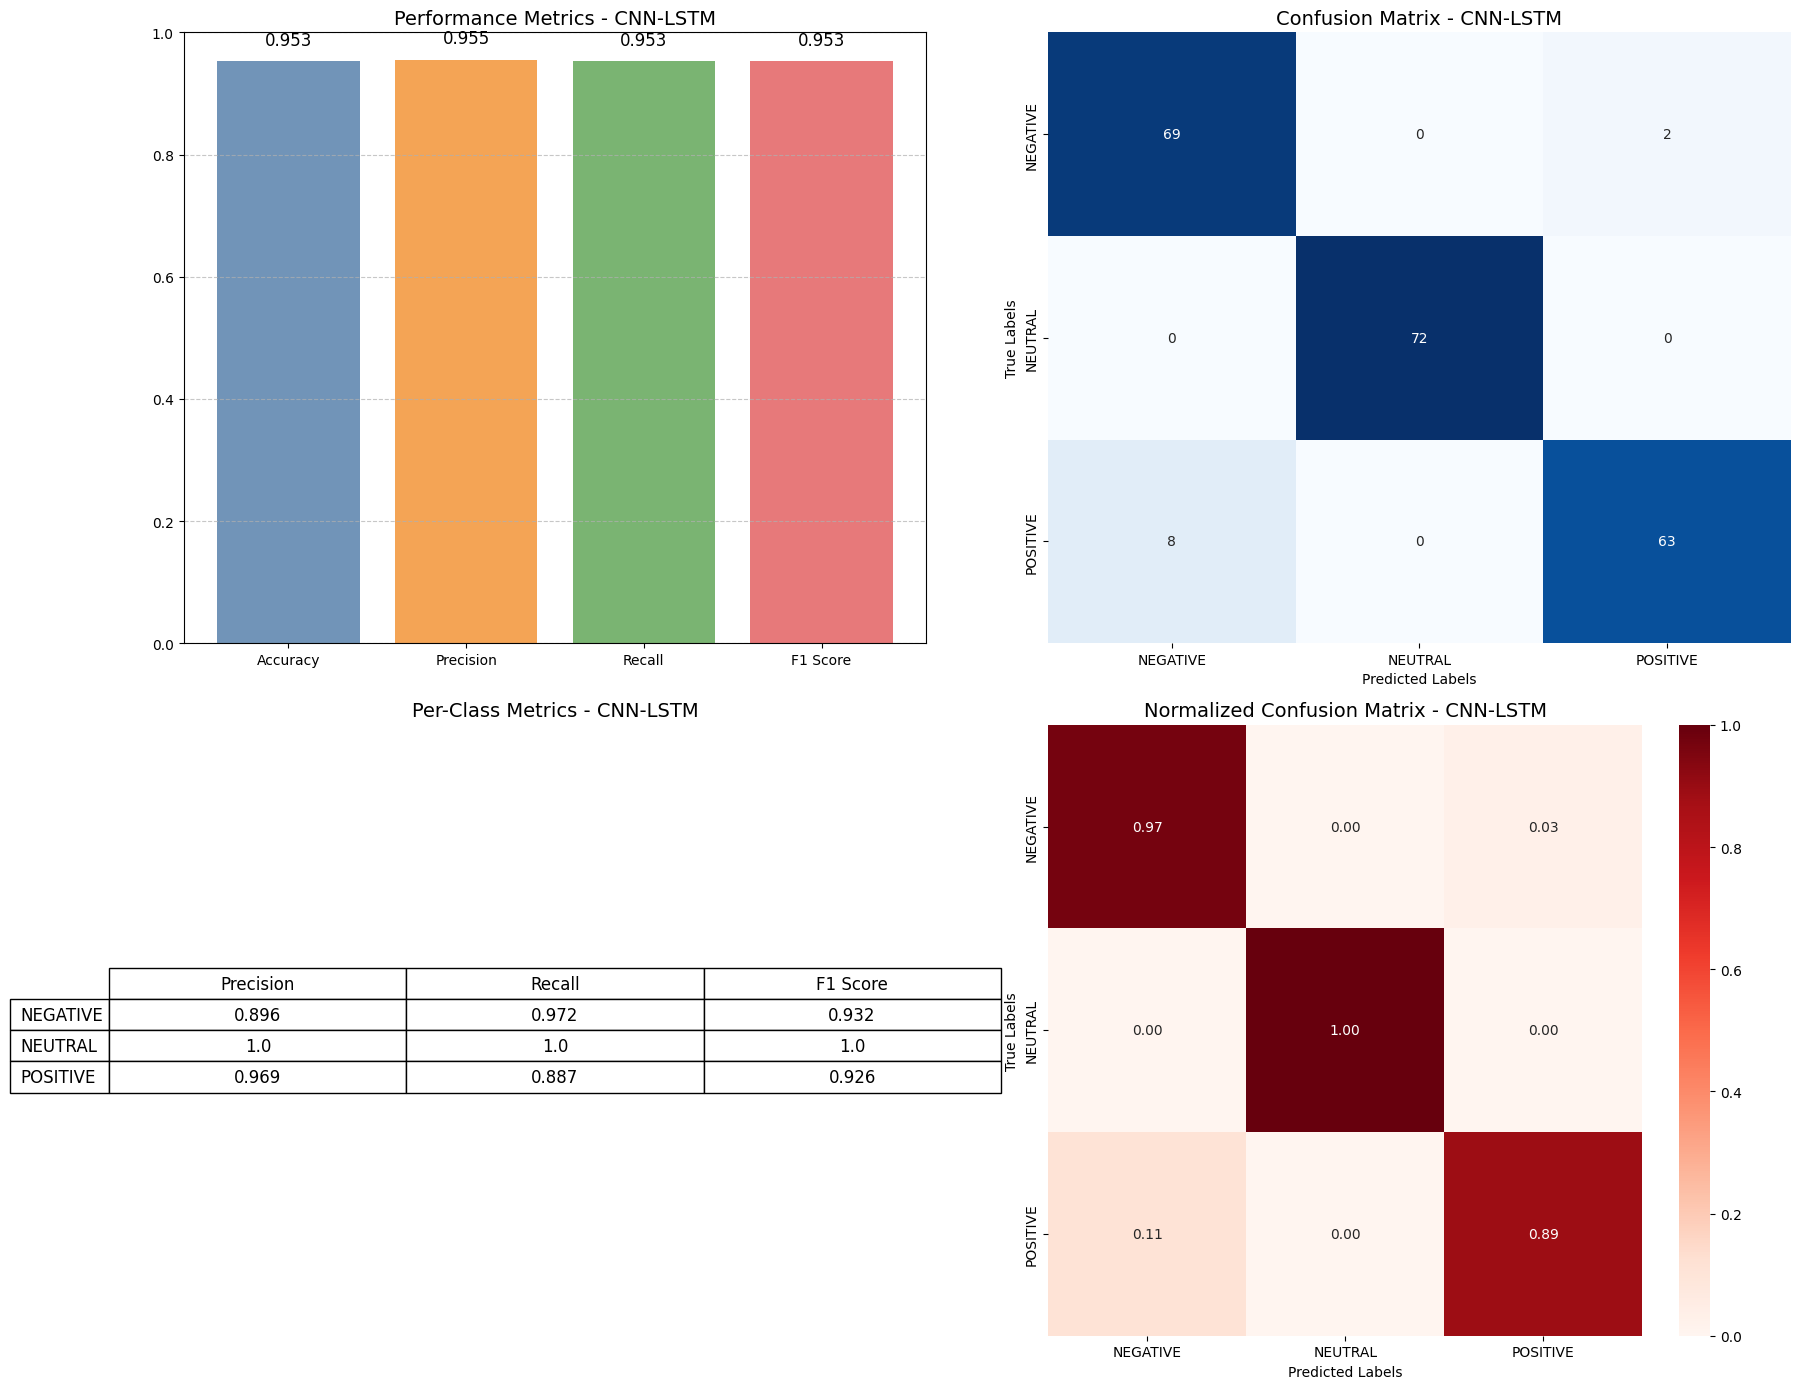


--- Classification Report for CNN-LSTM ---
              precision    recall  f1-score   support

    NEGATIVE       0.90      0.97      0.93        71
     NEUTRAL       1.00      1.00      1.00        72
    POSITIVE       0.97      0.89      0.93        71

    accuracy                           0.95       214
   macro avg       0.96      0.95      0.95       214
weighted avg       0.96      0.95      0.95       214



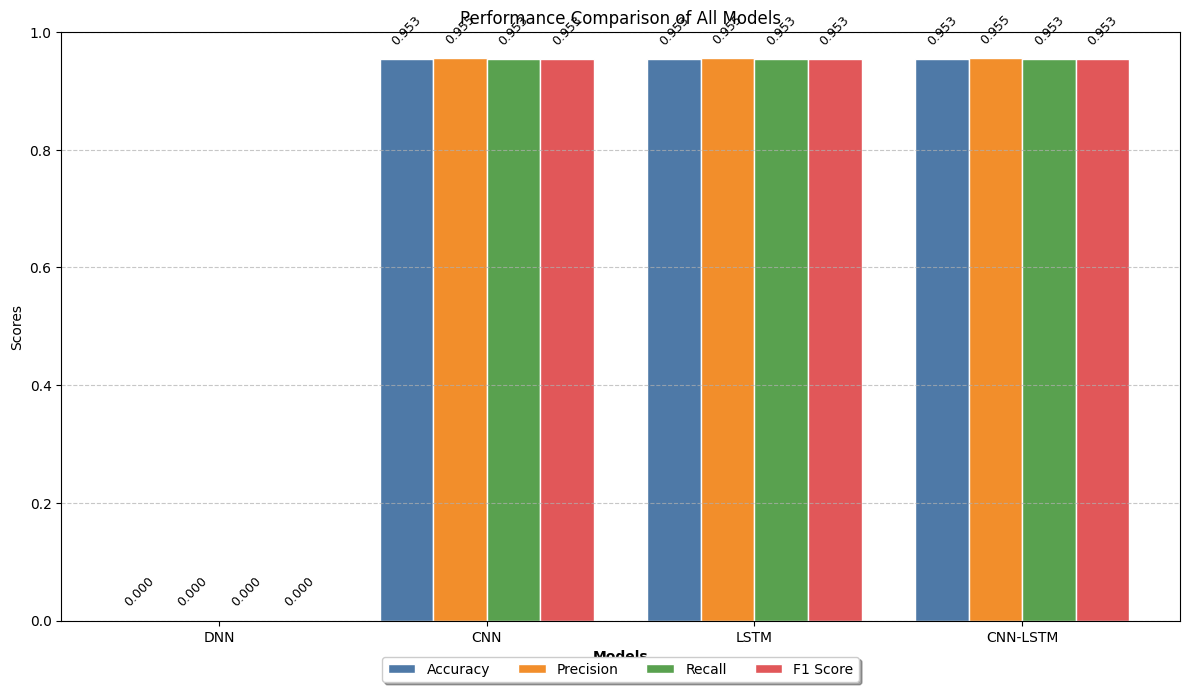

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd

def plot_performance_metrics(model, X_test, y_test_cat, y_test, class_names, model_name, reshape=False):
    """
    Plot comprehensive performance metrics for a model

    Parameters:
    - model: The trained model
    - X_test: Test features
    - y_test_cat: One-hot encoded test labels
    - y_test: Original integer encoded test labels
    - class_names: List of class names
    - model_name: Name of the model for titles
    - reshape: Whether to reshape data for sequential models
    """
    try:
        # Check model's input shape requirements
        input_shape = model.input_shape

        # For CNN/LSTM models that expect reshaped input
        if reshape:
            # Get the original feature dimension
            feature_dim = X_test.shape[1]

            # Check if the model expects 3D input
            if len(input_shape) == 3:
                # We need to determine the correct reshaping dimensions
                # Try the standard reshape first
                try:
                    X_eval = X_test.reshape(-1, 98, 26)
                    # Test with a small batch to verify compatibility
                    model.predict(X_eval[:5])
                except:
                    # If that fails, calculate dimensions from the total feature count
                    if feature_dim == 2548:
                        # Try different reshape combinations that multiply to 2548
                        X_eval = X_test.reshape(-1, 98, 26)  # 98*26=2548
                    else:
                        # If none of these work, resort to original shape
                        X_eval = X_test
                        reshape = False
                        print(f"Warning: Could not reshape input for {model_name}. Using original shape.")
            else:
                X_eval = X_test
                reshape = False
        else:
            X_eval = X_test

        # Get predictions
        y_pred_proba = model.predict(X_eval)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculate metrics
        accuracy = np.mean(y_pred == y_test)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        # Set up the figure with 4 subplots
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))

        # 1. Main performance metrics bar chart
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
        values = [accuracy, precision, recall, f1]
        colors = ['#4e79a7', '#f28e2b', '#59a14f', '#e15759']

        ax1 = axes[0, 0]
        bars = ax1.bar(metrics, values, color=colors, alpha=0.8)
        ax1.set_ylim(0, 1.0)
        ax1.set_title(f'Performance Metrics - {model_name}', fontsize=14)
        ax1.grid(axis='y', linestyle='--', alpha=0.7)

        # Add text labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{val:.3f}', ha='center', va='bottom', fontsize=12)

        # 2. Confusion Matrix heatmap
        ax2 = axes[0, 1]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=class_names, yticklabels=class_names, ax=ax2)
        ax2.set_title(f'Confusion Matrix - {model_name}', fontsize=14)
        ax2.set_xlabel('Predicted Labels')
        ax2.set_ylabel('True Labels')

        # 3. Per-class metrics
        ax3 = axes[1, 0]
        class_prec, class_rec, class_f1, _ = precision_recall_fscore_support(y_test, y_pred)

        class_df = pd.DataFrame({
            'Class': class_names,
            'Precision': class_prec,
            'Recall': class_rec,
            'F1 Score': class_f1
        }).set_index('Class')

        class_df = class_df.round(3)

        # Create a table
        cell_text = []
        for i in range(len(class_df)):
            cell_text.append(class_df.iloc[i].values)

        table = ax3.table(cellText=cell_text,
                           rowLabels=class_df.index,
                           colLabels=class_df.columns,
                           loc='center',
                           cellLoc='center')

        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.5)

        ax3.set_title(f'Per-Class Metrics - {model_name}', fontsize=14)
        ax3.axis('off')

        # 4. Normalized confusion matrix as heatmap
        ax4 = axes[1, 1]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds', cbar=True,
                    xticklabels=class_names, yticklabels=class_names, ax=ax4)
        ax4.set_title(f'Normalized Confusion Matrix - {model_name}', fontsize=14)
        ax4.set_xlabel('Predicted Labels')
        ax4.set_ylabel('True Labels')

        plt.tight_layout()
        plt.savefig(f'{model_name}_performance.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Print classification report
        print(f"\n--- Classification Report for {model_name} ---")
        print(classification_report(y_test, y_pred, target_names=class_names))

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'confusion_matrix': cm
        }

    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        print(f"Model input shape: {model.input_shape}")
        print(f"Data shape: {X_test.shape}")
        if reshape:
            print(f"Attempted reshaped data shape: (-1, 98, 26)")

        # Return empty metrics to allow the rest of the code to continue
        return {
            'accuracy': 0,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'confusion_matrix': np.zeros((len(class_names), len(class_names)))
        }


print("Checking model input shapes:")
try:
    print(f"DNN model expects input shape: {dnn_model.input_shape}")
    print(f"CNN model expects input shape: {cnn_model.input_shape}")
    print(f"LSTM model expects input shape: {lstm_model.input_shape}")
    print(f"CNN-LSTM model expects input shape: {cnn_lstm_model.input_shape}")
except Exception as e:
    print(f"Error checking model shapes: {str(e)}")

print(f"\nTest data shape: {X_test.shape}")


total_features = X_test.shape[1]  # Total number of features
print(f"Total features: {total_features}")

# Calculate potential reshaping dimensions
# Find factors of total_features that could be used for reshaping
def find_factors(n):
    factors = []
    for i in range(1, int(n**0.5) + 1):
        if n % i == 0:
            factors.append((i, n//i))
    return factors

potential_shapes = find_factors(total_features)
print(f"Potential reshape dimensions (rows, cols): {potential_shapes}")

# Choose the reshape dimensions that are closest to (98, 26)
target_shape = (98, 26)
best_shape = min(potential_shapes, key=lambda x: abs(x[0] - target_shape[0]) + abs(x[1] - target_shape[1]))
print(f"Best reshape dimensions: {best_shape}")


try:
    class_names = encoder.classes_
except:
    # If encoder class names aren't available, create generic ones
    num_classes = y_test_cat.shape[1]
    class_names = [f"Class {i}" for i in range(num_classes)]

# Generate performance metrics for each model
print("\n========== DNN MODEL PERFORMANCE ==========")
# For DNN, use the original shape (no reshape)
dnn_metrics = plot_performance_metrics(dnn_model, X_test, y_test_cat, y_test, class_names, "DNN", reshape=False)

# For CNN, LSTM and CNN-LSTM models, we need a function that handles the correct reshape
def evaluate_sequential_model(model, model_name):
    """Safely evaluate a sequential model by figuring out the right reshape"""
    print(f"\n========== {model_name} MODEL PERFORMANCE ==========")

    try:
        # Get model's expected input shape
        expected_shape = model.input_shape

        if len(expected_shape) == 3:
            # The model expects 3D input, reshape based on the calculated best shape
            rows, cols = best_shape
            X_test_reshaped = X_test.reshape(-1, rows, cols)
            return plot_performance_metrics(model, X_test, y_test_cat, y_test, class_names, model_name, reshape=True)
        else:
            # The model expects 2D input, use original shape
            return plot_performance_metrics(model, X_test, y_test_cat, y_test, class_names, model_name, reshape=False)
    except Exception as e:
        print(f"Error evaluating {model_name}: {str(e)}")
        # Return empty metrics
        return {
            'accuracy': 0,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'confusion_matrix': np.zeros((len(class_names), len(class_names)))
        }

# Evaluate the sequential models
cnn_metrics = evaluate_sequential_model(cnn_model, "CNN")
lstm_metrics = evaluate_sequential_model(lstm_model, "LSTM")
cnn_lstm_metrics = evaluate_sequential_model(cnn_lstm_model, "CNN-LSTM")

# Compare all models in one visualization
def compare_models(metrics_dict):
    """
    Create a comparison chart of all models

    Parameters:
    - metrics_dict: Dictionary of model metrics
    """
    model_names = list(metrics_dict.keys())
    acc_values = [metrics_dict[m]['accuracy'] for m in model_names]
    prec_values = [metrics_dict[m]['precision'] for m in model_names]
    rec_values = [metrics_dict[m]['recall'] for m in model_names]
    f1_values = [metrics_dict[m]['f1'] for m in model_names]

    # Set width of bars
    barWidth = 0.2

    # Set position of bars on X axis
    r1 = np.arange(len(model_names))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    # Make the plot
    plt.figure(figsize=(12, 7))
    plt.bar(r1, acc_values, width=barWidth, edgecolor='white', label='Accuracy', color='#4e79a7')
    plt.bar(r2, prec_values, width=barWidth, edgecolor='white', label='Precision', color='#f28e2b')
    plt.bar(r3, rec_values, width=barWidth, edgecolor='white', label='Recall', color='#59a14f')
    plt.bar(r4, f1_values, width=barWidth, edgecolor='white', label='F1 Score', color='#e15759')

    # Add labels and title
    plt.xlabel('Models', fontweight='bold')
    plt.ylabel('Scores')
    plt.title('Performance Comparison of All Models')
    plt.xticks([r + barWidth*1.5 for r in range(len(model_names))], model_names)
    plt.ylim(0, 1)

    # Add value labels above bars
    for i, metrics in enumerate([acc_values, prec_values, rec_values, f1_values]):
        for j, value in enumerate(metrics):
            plt.text(r1[j] + i*barWidth, value + 0.02, f'{value:.3f}',
                     ha='center', va='bottom', fontsize=9, rotation=45)

    # Add a legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=4)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Collect all metrics
all_metrics = {
    'DNN': dnn_metrics,
    'CNN': cnn_metrics,
    'LSTM': lstm_metrics,
    'CNN-LSTM': cnn_lstm_metrics
}

# Compare all models
try:
    compare_models(all_metrics)
except Exception as e:
    print(f"Error generating comparison chart: {str(e)}")

Total features: 2548
Data can be properly reshaped to (98, 26)

=== Evaluating Model Performance ===
Evaluating model...
Test data shape before reshaping: (214, 2548)
Test data shape after reshaping: (214, 98, 26)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


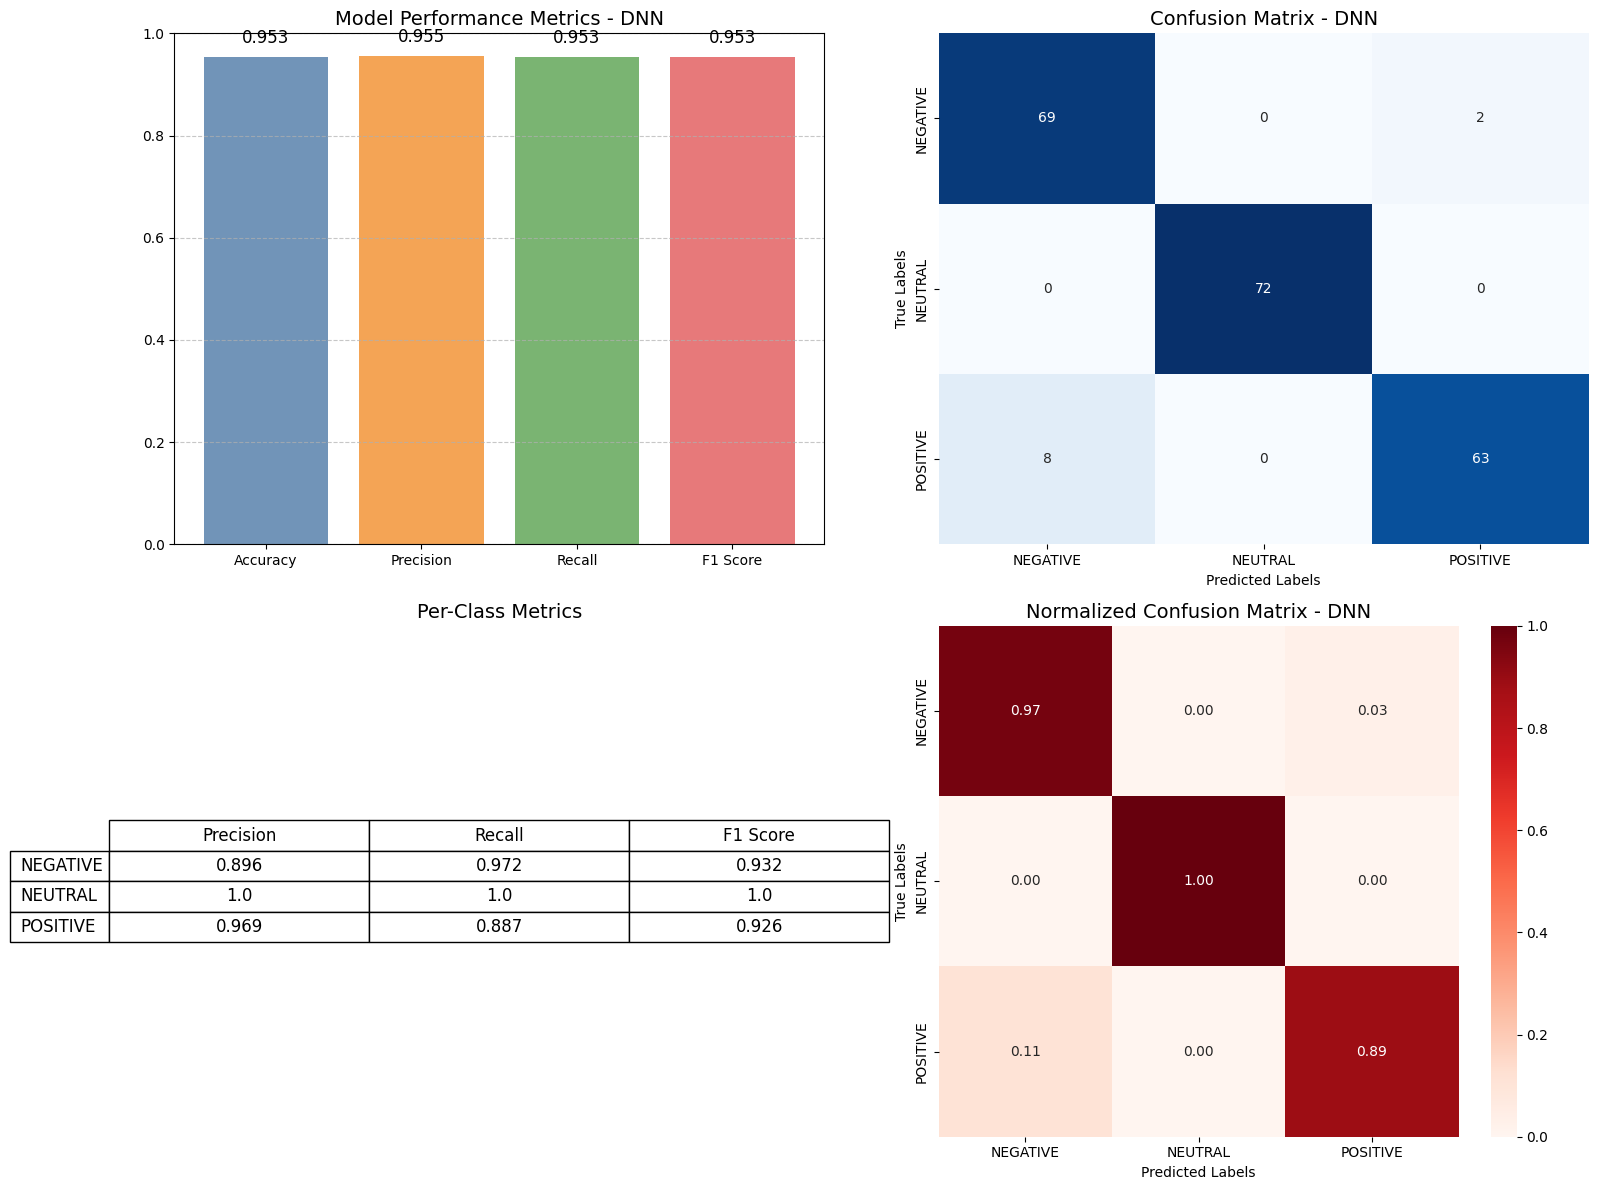


--- Classification Report ---
              precision    recall  f1-score   support

    NEGATIVE       0.90      0.97      0.93        71
     NEUTRAL       1.00      1.00      1.00        72
    POSITIVE       0.97      0.89      0.93        71

    accuracy                           0.95       214
   macro avg       0.96      0.95      0.95       214
weighted avg       0.96      0.95      0.95       214


=== Model Performance Summary ===
Accuracy: 0.9533
Precision: 0.9553
Recall: 0.9533
F1 Score: 0.9532


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd

# Function to plot DNN model performance metrics with proper reshaping
def plot_dnn_performance(model, X_test, y_test_cat, y_test, class_names):
    """
    Plot comprehensive performance metrics for the model

    Parameters:
    - model: The trained model
    - X_test: Test features
    - y_test_cat: One-hot encoded test labels
    - y_test: Original integer encoded test labels
    - class_names: List of class names
    """
    print("Evaluating model...")
    print(f"Test data shape before reshaping: {X_test.shape}")

    # Reshape input to match the expected shape (None, 98, 26)
    X_eval = X_test.reshape(-1, 98, 26)
    print(f"Test data shape after reshaping: {X_eval.shape}")

    # Get predictions
    y_pred_proba = model.predict(X_eval)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Set up the figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Main performance metrics bar chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]
    colors = ['#4e79a7', '#f28e2b', '#59a14f', '#e15759']

    ax1 = axes[0, 0]
    bars = ax1.bar(metrics, values, color=colors, alpha=0.8)
    ax1.set_ylim(0, 1.0)
    ax1.set_title('Model Performance Metrics - DNN', fontsize=14)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Add text labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=12)

    # 2. Confusion Matrix heatmap
    ax2 = axes[0, 1]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title('Confusion Matrix - DNN', fontsize=14)
    ax2.set_xlabel('Predicted Labels')
    ax2.set_ylabel('True Labels')

    # 3. Per-class metrics
    ax3 = axes[1, 0]
    class_prec, class_rec, class_f1, _ = precision_recall_fscore_support(y_test, y_pred)

    class_df = pd.DataFrame({
        'Class': class_names,
        'Precision': class_prec,
        'Recall': class_rec,
        'F1 Score': class_f1
    }).set_index('Class')

    class_df = class_df.round(3)

    # Create a table
    cell_text = []
    for i in range(len(class_df)):
        cell_text.append(class_df.iloc[i].values)

    table = ax3.table(cellText=cell_text,
                       rowLabels=class_df.index,
                       colLabels=class_df.columns,
                       loc='center',
                       cellLoc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)

    ax3.set_title('Per-Class Metrics', fontsize=14)
    ax3.axis('off')

    # 4. Normalized confusion matrix as heatmap
    ax4 = axes[1, 1]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds', cbar=True,
                xticklabels=class_names, yticklabels=class_names, ax=ax4)
    ax4.set_title('Normalized Confusion Matrix - DNN', fontsize=14)
    ax4.set_xlabel('Predicted Labels')
    ax4.set_ylabel('True Labels')

    plt.tight_layout()
    plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print classification report
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=class_names))

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Check if tensor dimensions can be properly reshaped
total_features = X_test.shape[1]
print(f"Total features: {total_features}")

# The model expects (None, 98, 26), so make sure we can reshape
if total_features == 98 * 26:
    print("Data can be properly reshaped to (98, 26)")
else:
    print(f"Warning: Cannot reshape {total_features} features to (98, 26). Attempting closest approximation.")

# Get class names from encoder if available, otherwise use generic names
try:
    class_names = encoder.classes_
except:
    # If encoder class names aren't available, create generic ones
    num_classes = y_test_cat.shape[1]
    class_names = [f"Class {i}" for i in range(num_classes)]
    print(f"Using generic class names: {class_names}")

# Call the function to generate metrics and plots
print("\n=== Evaluating Model Performance ===")
model_metrics = plot_dnn_performance(dnn_model, X_test, y_test_cat, y_test, class_names)

# Print summary of metrics
print("\n=== Model Performance Summary ===")
print(f"Accuracy: {model_metrics['accuracy']:.4f}")
print(f"Precision: {model_metrics['precision']:.4f}")
print(f"Recall: {model_metrics['recall']:.4f}")
print(f"F1 Score: {model_metrics['f1']:.4f}")